Here I construct the initial force field Lenard-Jone potential and Coulume potential from UFF and MIL-120 from aiida-plugin

The force field file in RASPA: epsilon units (Kelvin); sigma(Angstrom)

Al_     LENNARD_JONES   254.152 4.0082
C_      LENNARD_JONES   52.8435 3.4309
H_      LENNARD_JONES   22.1439 2.5711
O_      LENNARD_JONES   30.1963 3.1181
O_co2   LENNARD_JONES   79.0    3.05
C_co2   LENNARD_JONES   27.0    2.80

The force field file in OpenMM: epsilon units (KJ/mol); sigma(nm)

Al_     LENNARD_JONES   2.1019    0.40082
C_      LENNARD_JONES   0.4400    0.34309
H_      LENNARD_JONES   0.1841    0.25711
O_      LENNARD_JONES   0.2513    0.31181
O_co2   LENNARD_JONES   0.6577    0.30500
C_co2   LENNARD_JONES   0.2249    0.28000

Some prepared files to run the simulation: (I put all of them in data directory)


It is not easy to generate these files. Bullshit PDB and xml files. I save some childish methods in refine.ipynb to do it. 
If I have time, maybe write new functions to unils.py

Structural file of MOF: 
atoms in pdb file should have a special name

gas.pdb: CO2 molecule predicted by UFF force field
MIL-120.pdb: The rigid framework

A good force field:
custom_force_field.xml, containing charges information from CIF file

In [76]:
# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology

# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading
from utils import cutoff_topology
import matplotlib.pyplot as plt

In [348]:
"""

Superparameters for Lenard-Jone Potential optimization

"""
particle_number =  500             #液体pdb文件中的分子数
target_han= 50.52                  #拟合的目标蒸发焓
SET_temperature=  293.15           #温度设定
time_gap=   2.5                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   50                   #迭代循环次数    推荐50-100
save_step =   125                  #保存的frame数  推荐150-200
skip_step =    25                   #计算各种物理常数之前，达到平衡所需要的步数
length_step = (skip_step+save_step) #分子动力学模拟生成的dcd文件存储的frame个数，与time_gap共同决定总模拟的时长，总时长=length_step*time_gap
scaling_factors = (4,4,3)
cutoff = 1 #1.3 # unit is nanometer

In [350]:
import openmm.app as app
import openmm as mm
import openmm.unit as unit

def compute_energy(topo, pos, ff, cutoff=cutoff, removeLJ=False):
    global SET_temperature, time_gap
    system = ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=cutoff*unit.nanometer, constraints=None, removeCMMotion=False)
    
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
            if removeLJ:
                for npart in range(force.getNumParticles()):
                    chrg, sig, eps = force.getParticleParameters(npart)
                    force.setParticleParameters(npart, chrg, 1.0, 0.0)
                for nex in range(force.getNumExceptions()):
                    p1, p2, chrg, sig, eps = force.getExceptionParameters(nex)
                    force.setExceptionParameters(nex, p1, p2, chrg, 1.0, 0.0)

    integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, time_gap*unit.femtosecond)
    simulation = app.Simulation(topo, system, integ)
    simulation.context.setPositions(pos)
    state=simulation.context.getState(getEnergy=True)
    potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
    print()
    return potential_energy.value_in_unit(unit.kilojoules_per_mole)
    # Calculate the energy components (Lennard-Jones and Coulombic)
    lj_energy = context.getState(getEnergy=True, groups={0}).getPotentialEnergy()  # Assuming LJ group index is 0
    coulomb_energy = context.getState(getEnergy=True, groups={1}).getPotentialEnergy()  # Assuming Coulomb group index is 1
    
def binding_energy(pdb, ff, cutoff=cutoff):
    frame_topo, gas_topo = cutoff_topology(pdb.topology)
    positions = pdb.getPositions()
    total_ener = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)
    frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)
    gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)
    return total_ener-frame_ener-gas_ener

In [351]:

"""

Test part: Ensure openmm get the same binding energy to the results from raspa

"""

# For site 1

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/gas.pdb","loading_supercell.pdb")
pdb = app.PDBFile("loading_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb,ff))

# For site 2

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/site2.pdb","loading_supercell.pdb")
pdb = app.PDBFile("loading_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb,ff))





This is binding energy: -61.75506881379451



This is binding energy: -47.06147760948064


In [352]:
pdb = app.PDBFile("loading_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

223538872.9206104

In [381]:
pdb = app.PDBFile("loading_supercell.pdb")
pdb = app.PDBFile("test.pdb")
ff = app.ForceField("custom_forcefield.xml")

compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

209875696.7531967

In [299]:
223538996.81798586-223538490.20915982

506.6088260412216

In [380]:
#pdb = app.PDBFile("loading_supercell.pdb")
pdb = app.PDBFile("loading_supercell.pdb")
pdb = app.PDBFile("test.pdb")
dmfftop = dmff.DMFFTopology(pdb.topology)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()


xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(pdb.getPositions().value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))

nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
pairs = jnp.array(nblist.allocate(pos_jnp, cell_jnp))
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
print(ener)

209876092.24104246


In [382]:
209875696.7531967-209876092.24104246

-395.48784577846527

In [364]:
pos_jnp.shape

(1923, 3)

In [367]:
pairs.shape

(406777, 3)

In [361]:
nblist

In [354]:
223538490.20915982-223539461.54737312

-971.3382132947445

In [337]:
print(cell_jnp)

[[ 2.8696      0.          0.        ]
 [-0.3293191   2.97341882  0.        ]
 [-0.94493837 -1.11477557  2.99987809]]


In [338]:
print(pos_jnp)

[[ 1.300e-03 -1.000e-04  5.840e-01]
 [ 3.188e-01  3.718e-01  4.160e-01]
 [-1.986e-01  1.859e-01  5.000e-01]
 ...
 [-3.750e-02  2.918e-01  1.157e-01]
 [-3.900e-02  2.910e-01 -3.000e-04]
 [-4.070e-02  2.902e-01 -1.163e-01]]


In [315]:
paramset[lj_gen.name]

{'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
 'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
 'sigma_nbfix': Array([], dtype=float64),
 'epsilon_nbfix': Array([], dtype=float64)}

In [311]:
#pdb = app.PDBFile("loading_supercell.pdb")
pdb = app.PDBFile("loading_supercell.pdb")

dmfftop = dmff.DMFFTopology(pdb.topology)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()


xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(pdb.getPositions().value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))

nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
pairs = jnp.array(nblist.allocate(pos_jnp, cell_jnp))
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
print(ener)

223538996.81798586


In [312]:
paramset[lj_gen.name]

{'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
 'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
 'sigma_nbfix': Array([], dtype=float64),
 'epsilon_nbfix': Array([], dtype=float64)}

In [306]:
223538996.81798586-223540399.81034195

-1402.9923560917377

In [ ]:
223538490.20915982

In [294]:
lj_gen.atype_to_idx

{'Al': 0, 'C': 1, 'H': 2, 'O': 3, 'O_co2': 4, 'C_co2': 5}

In [287]:
223538490.20915982-223538998.76296434

-508.5538045167923

In [280]:
print(cutoff)

1.4


223539463.4830464


In [ ]:
lj_force(,paramset)

In [218]:
topdata = dmfftop
atoms = [a for a in topdata.atoms()]
atypes = [a.meta["type"] for a in atoms]

KeyError: 'type'

In [232]:
topdata = dmfftop
for atom in dmfftop.atoms():
    atom.meta['type']=atom.meta['element']
    atom.meta['class']=atom.meta['element']
#atoms = [a for a in topdata.atoms()]
#atypes = [a.meta["type"] for a in atoms]

In [230]:
dmfftop = DMFFTopology(pdb.topology)

In [216]:
topdata = pdb.topology
atoms = [a for a in topdata.atoms()]
atypes = [a.meta["type"] for a in atoms]

AttributeError: 'Atom' object has no attribute 'meta'

In [234]:
lj_gen = LennardJonesGenerator(ffinfo, paramset)
#dmfftop = dmff.DMFFTopology(pdb.topology)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

In [224]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
dmfftop = dmff.DMFFTopology(pdb.topology)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=1.0, args={})

KeyError: 'type'

In [204]:
lj_operator = ParmedLennardJonesOperator(pdb.topology)
lj_operator.renderLennardJonesXML("data/init.xml")

In [205]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    lj_operator, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=1.0, args={})

AttributeError: 'ParmedLennardJonesOperator' object has no attribute 'atoms'

This part just for curiosity:
Study on how the cutoff influences on energy computation

In [ ]:
cutoff_arr = np.linspace(0.3,0.999,10)
ls_1 = [compute_energy(pdb.topology,positions,ff, cutoff=i) for i in cutoff_arr]
ls_2 = [compute_energy(frame_topo,positions[:-3],ff, cutoff=i) for i in cutoff_arr]
ls_3 = [compute_energy(gas_topo,positions[-3:],ff, cutoff=i) for i in cutoff_arr]

In [207]:
pdb.topology

<Topology; 1 chains, 49 residues, 1923 atoms, 2 bonds>

In [210]:
dmff.DMFFTopology(pdb.topology)

<DMFFTopology; 1 chains, 49 residues, 1923 atoms, 2 bonds>

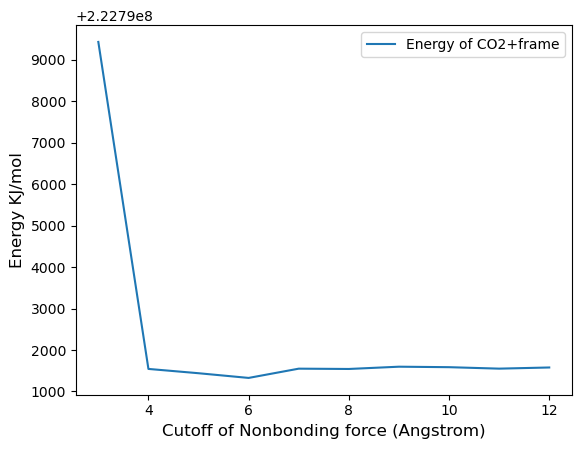

In [101]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_1,label="Energy of CO2+frame")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

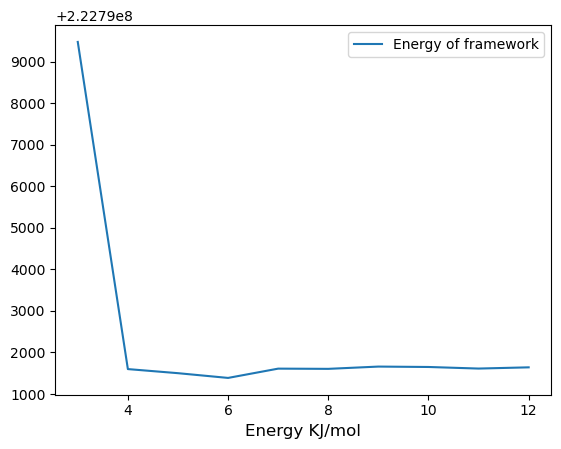

In [98]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_2,label="Energy of framework")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.xlabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()


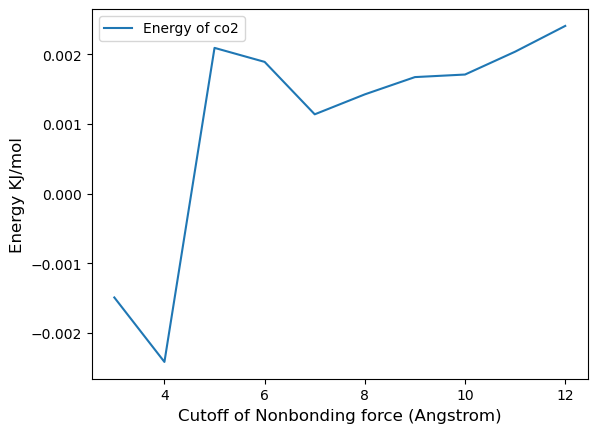

In [97]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_3,label="Energy of co2")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

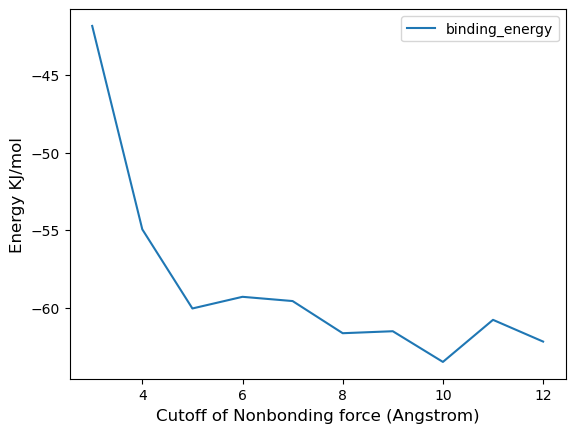

In [102]:
ls_all = [i-j-k for i,j,k in zip(ls_1,ls_2,ls_3)]
plt.plot(cutoff_arr*10,ls_all,label="binding_energy")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

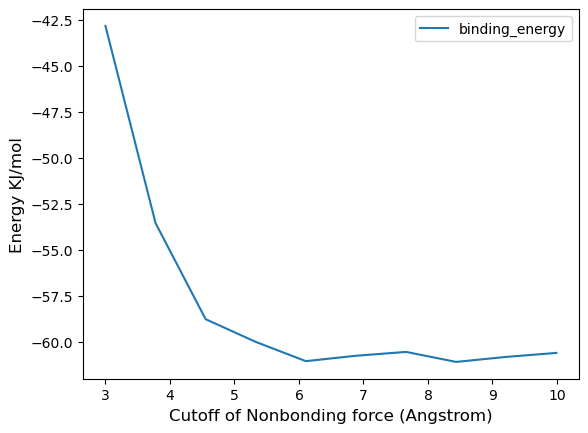

In [108]:

ls_all = [i-j-k for i,j,k in zip(ls_1,ls_2,ls_3)]
plt.plot(cutoff_arr*10,ls_all,label="binding_energy")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

In [3]:
ner_ls = []

positions=initial_positions[:]

topo = pdb.topology
pos = positions[:]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)

topo = frame_top
pos = positions[:40]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)


topo = gas_top
pos = positions[40:]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)

print("This is interaction energy: ", ener_ls[0]-ener_ls[1]-ener_ls[2])